# Exploring the Effects of Perturbations on Saliency Map Generation

The link between saliency maps and model generalization is currently unclear. This is a simple notebook exploring how perturbations might effect saliency maps, using tools provided by `maite` and `xaitk-saliency`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Images](#example-images)
* [Defining the "Application"](#defining-the-application)
* [Running the "Application"](#running-the-application)
    * [Classifier](#classifier)
    * [Saliency Generator](#saliency-generator)
    * [Results](#results)

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-cdao...")
!{sys.executable} -m pip install -q ..
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing albumentations...")
!{sys.executable} -m pip install -q albumentations==1.3.1
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing tabulate...")
!{sys.executable} -m pip install -q tabulate
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip -q install torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing xaitk-cdao...
Installing xaitk-saliency...
Installing albumentations...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing tabulate...
Installing torch...
Installing torchvision...
Installing matplotlib...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore

from dataclasses import dataclass, field
from datasets import load_dataset  # type: ignore
from PIL import Image
from scipy.stats import entropy
from tabulate import tabulate
from typing import Hashable, List, Optional, Sequence, Tuple
import albumentations as A # type: ignore
import numpy as np
import numpy.typing as npt

from maite.interop.augmentation import AugmentationWrapper
from maite.interop.huggingface import HuggingFaceImageClassifier
from maite.protocols import SupportsArray

from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_cdao.interop.image_classification import JATICImageClassifier
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency

## Example Images <a name="example-images"></a>

We'll use example images from the CIFAR-10 test dataset, but this could be expanded to many images -- even across a dataset.

In [3]:
data = load_dataset("cifar10", split="test")
labels = data.features['label'].names

data.set_transform(lambda x: {"image": x["img"], "label": x["label"]})

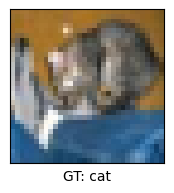

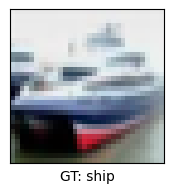

In [4]:
num_samples = 2
imgs = np.asarray([np.asarray(data[idx]["image"]) for idx in range(num_samples)])
ground_truth = [data[idx]["label"] for idx in range(num_samples)]

for img, gt in zip(imgs, ground_truth):
    plt.figure(figsize=(2,2))
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(f"GT: {labels[gt]}")
    _ = plt.imshow(img)

## Defining the "Application" <a name="defining-the-application"></a>

First we'll define a couple of dataclasses to keep track of results more easily:

In [5]:
@dataclass
class PerturbationResult:
    descriptor: str
    img: np.ndarray
    sal_maps: np.ndarray
    pred_class: int
    pred_prob: float
    
@dataclass
class SaliencyResults:
    ref_img: np.ndarray
    ref_sal_maps: np.ndarray
    gt: int
    pred_class: int
    pred_prob: float
    perturbations: List[PerturbationResult] = field(default_factory=list)

Next, we'll define a function to compute specified metrics upon our saliency map results.

In [6]:
def compute_metrics(results: List[SaliencyResults], labels: Sequence[Hashable], metrics: Tuple[str, ...]):    
    def _compute_entropy(sal_map: np.ndarray, clip_min, clip_max) -> float:
        if clip_min is not None or clip_max is not None:
            s = np.clip(sal_map, clip_min, clip_max)
        else:
            s = (sal_map - sal_map.min()) / (sal_map.max() - sal_map.min())
        return entropy(s.ravel(), base=2) # type: ignore
    
    def _compute_ssd(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
        sum_sq_diff = np.sum(np.power(np.subtract(sal_map, ref_sal_map), 2))
        norm = np.sqrt(np.sum(np.power(sal_map, 2)) * np.sum(np.power(ref_sal_map, 2)))
        if not norm:
            return np.inf
        return sum_sq_diff / norm
    
    def _compute_xcorr(sal_map: np.ndarray, ref_sal_map: np.ndarray) -> float:
        def _normalize(s: np.ndarray):
            s -= s.mean()
            std = s.std()
            
            if std:
                s /= std
                
            return s, std == 0
        
        s1, c1 = _normalize(sal_map.copy())
        s2, c2 = _normalize(ref_sal_map.copy())
        
        if c1 and not c2:
            return 0.
        else:
            return np.corrcoef(s1.flatten(), s2.flatten())[0, 1]
        
    def _compute_metric(sal_map: np.ndarray, ref_sal_map: np.ndarray, m: str) -> float:         
        if m == "entropy":
            return _compute_entropy(sal_map, None, None)
        elif m == "pos saliency entropy":
            return _compute_entropy(sal_map, 0, 1)
        elif m == "neg saliency entropy":
            return _compute_entropy(sal_map, -1, 0)
        elif m == "ssd":
            return _compute_ssd(sal_map, ref_sal_map)
        elif m == "xcorr":
            return _compute_xcorr(sal_map, ref_sal_map)
        else:
            return np.nan
        
    def _generate_row(sal_map: np.ndarray, ref_sal_map: np.ndarray, row_label: str) -> List[Hashable]:
        r: List[Hashable] = [row_label]
        
        for metric in metrics:
            r.append(_compute_metric(sal_map, ref_sal_map, metric.lower().strip()))
                     
        return r
            
    headers = ["Perturbation"]
    headers.extend(list(metrics))
    for res in results:
        rows = []
        
        rows.append(
            _generate_row(
                res.ref_sal_maps[res.gt], 
                res.ref_sal_maps[res.gt], 
                f"Ref Image"
        ))
                     
        for pert in res.perturbations:
            rows.append(
                _generate_row(
                    pert.sal_maps[res.gt], 
                    res.ref_sal_maps[res.gt], 
                    f"{pert.descriptor}"
            ))
                     
        print(tabulate(rows, headers=headers, tablefmt="fancy_grid"))

We'll also define a function to display all generated saliency maps.

In [7]:
def display_results(results: List[SaliencyResults], labels: Sequence[Hashable]):
    num_classes = len(labels)
    
    def _plot_img(img: np.ndarray, descriptor: str=""):
        plt.subplot(2, num_cols, 1)
        plt.imshow(img, cmap='gray')
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(descriptor)
            
    def _plot_rows(sal_maps: np.ndarray, plot_idxes: Optional[List[int]]=None):
        if plot_idxes is None:
            plot_idxes = [i for i in range(len(sal_maps))]
        else: # Remove duplicates
            plot_idxes = [*set(plot_idxes)]
        n_cols = min(num_cols - 1, len(plot_idxes)) 
        n_rows = 2

        num_imgs = 0
        for r in range(n_rows):
            col_offset = 2
            if r > 0:
                col_offset = 3
            for c in range(r * n_cols, min(r * n_cols + n_cols, len(plot_idxes))):
                plt.subplot(n_rows, num_cols, c + col_offset)
                im = plt.imshow(sal_maps[plot_idxes[c]], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[plot_idxes[c]]}")
                num_imgs += 1

                if num_imgs == len(plot_idxes):
                    fig = plt.gcf()
                    cax = fig.add_axes(tuple([0.38, 0.60, 0.01, 0.21]))  # tweaked for this particular example
                    plt.colorbar(im, cax=cax)
                
    for res in results:
        fig = plt.figure(figsize=(10,5))
        num_cols = np.ceil(num_classes/2).astype(int) + 1
        pred=f"{labels[res.pred_class]} ({res.pred_prob:.2f})"
        _plot_img(res.ref_img, f"Ref Img\nGT: {labels[res.gt]}\nPred: {pred}")
        _plot_rows(res.ref_sal_maps, [res.gt])
        
        for pert in res.perturbations:
            fig = plt.figure(figsize=(10,5))
            pred=f"{labels[pert.pred_class]} ({pert.pred_prob:.2f})"
            _plot_img(pert.img, f"{pert.descriptor}\nPred: {pred}")
            _plot_rows(pert.sal_maps, [res.gt])
            
    plt.show()

Finally, we'll define the "application" which perturbs the given input image(s) to varying degrees and generates saliency maps. In this case, we'll perturb the images using a Gaussian Blur while varying the `ksize` parameter to achieve different levels of degradation. To easily apply this perturbation, we'll use the `AugmentationWrapper` provided by the `maite` toolbox.

In [8]:
def generate_perturbed_sal_maps(
    images: np.ndarray,
    ground_truth: List[int],
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    ksizes: Tuple[int, ...],
    display_maps: bool = True,
    metrics: Tuple[str, ...] = ("Pos Saliency Entropy", "Neg Saliency Entropy", "Entropy", "SSD", "XCorr")
):  
    # Get class labels
    labels = image_classifier.get_labels()
    
    def _max_class(probs):
        v = list(probs.values())
        k = list(probs.keys())
        return k[v.index(max(v))]
    
    # Generate saliency maps
    results = list()
    for idx, img in enumerate(images):
        print(f"Generating saliency maps for reference image (image {idx+1} of {len(images)})")
        sal_maps = saliency_generator(img, image_classifier)
        probs = next(image_classifier.classify_images(np.expand_dims(img, axis=0)))
        pred_class = _max_class(probs)
        res = SaliencyResults(
            ref_img=np.copy(img), 
            ref_sal_maps=sal_maps,
            gt=ground_truth[idx],
            pred_class=labels.index(pred_class),
            pred_prob=probs[pred_class]
        )
        
        for k in ksizes:
            print(f"Generating saliency maps for ksize={k} (ref image {idx+1} of {len(images)})")
            xform = AugmentationWrapper(
                A.gaussian_blur,
                ksize=k
            )
            img_out = xform(np.copy(img)) 
            # TODO: Remove ignores after toolbox version updated
            sal_maps = saliency_generator(img_out, image_classifier)  # type: ignore
            probs = next(image_classifier.classify_images(np.expand_dims(img_out, axis=0)))  # type: ignore
            pred_class = _max_class(probs)
            
            pert = PerturbationResult(
                descriptor=f"ksize={k}",
                # TODO: Remove ignore after toolbox version updated
                img=img_out,  # type: ignore
                sal_maps=sal_maps,
                pred_class=labels.index(pred_class),
                pred_prob=probs[pred_class]
            )
            
            res.perturbations.append(pert)

        results.append(res)
        
    for result in results:
        # Plot each image in set with saliency maps
        if display_maps:
            display_results([result], labels)

        # Compute metrics
        compute_metrics([result], labels, metrics)

    return results

## Running the "Application" <a name="running-the-application"></a>

### Classifier <a name="classifier"></a>

We'll use the JATIC protocol-based classifier, along with the relevant `xaitk-saliency` adapter. We'll also define a preprocessor that converts our NumPy arrays to the PIL images that the model's default preprocessor expects. If we return PILs here, the default preprocessor will still run. Alternatively, we could fully redefine the preprocessor here, returning what the model directly expects as input, e.g. tensors.

In [9]:
jatic_classifier = HuggingFaceImageClassifier.from_pretrained("aaraki/vit-base-patch16-224-in21k-finetuned-cifar10")

def preprocessor(images: SupportsArray) -> SupportsArray:
    if isinstance(images, Sequence):
        preprocess_out = list()
        for img in images:
            preprocess_out.append(Image.fromarray(img))
        return preprocess_out
    else:
        return Image.fromarray(images)  # type: ignore #PIL is not considered ArrayLike currently
classifier = JATICImageClassifier(
    classifier=jatic_classifier,
    preprocessor=preprocessor
)

/home/local/KHQ/alexander.lynch/anaconda3/envs/new_xaitk/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/local/KHQ/alexander.lynch/anaconda3/envs/new_xaitk/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Saliency Generator <a name="saliency-generator"></a>

We'll use the `SlidingWindowStack` blackbox saliency generator.

In [10]:
sal_generator = SlidingWindowStack(
    window_size=(4, 4), 
    stride=(2, 2), 
    threads=4
)
sal_generator.fill = (128, 128, 128)

### Results <a name="results"></a>

Note: for clarity, we'll only be performing the saliency analysis with respect to the groundtruth class, but this analysis could also be applied to the predicted class, which may be useful in cases where the groundtruth and predictions may differ.

Generating saliency maps for reference image (image 1 of 2)
Generating saliency maps for ksize=3 (ref image 1 of 2)
Generating saliency maps for ksize=5 (ref image 1 of 2)
Generating saliency maps for ksize=7 (ref image 1 of 2)
Generating saliency maps for reference image (image 2 of 2)
Generating saliency maps for ksize=3 (ref image 2 of 2)
Generating saliency maps for ksize=5 (ref image 2 of 2)
Generating saliency maps for ksize=7 (ref image 2 of 2)


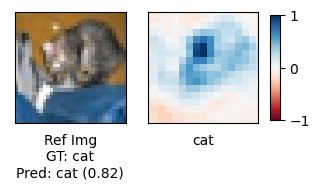

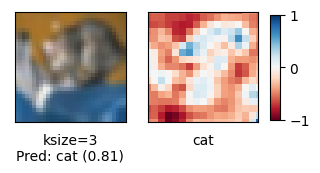

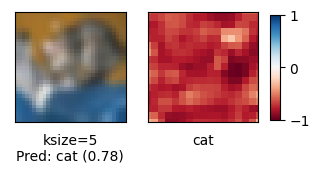

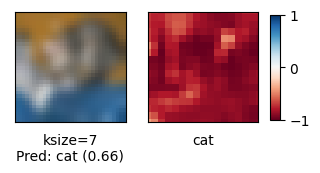

╒════════════════╤════════════════════════╤════════════════════════╤═══════════╤═════════╤═══════════╕
│ Perturbation   │   Pos Saliency Entropy │   Neg Saliency Entropy │   Entropy │     SSD │     XCorr │
╞════════════════╪════════════════════════╪════════════════════════╪═══════════╪═════════╪═══════════╡
│ Ref Image      │                9.02404 │                8.06984 │   9.75502 │ 0       │  1        │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=3        │                7.10899 │                9.44421 │   9.86029 │ 2.30665 │  0.542762 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=5        │              nan       │                9.98267 │   9.86491 │ 4.22987 │ -0.136331 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼─────────┼───────────┤
│ ksize=7        │              nan       │                9.98875 │   9.

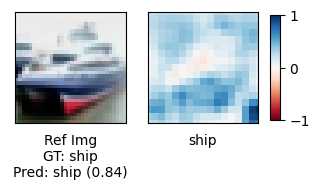

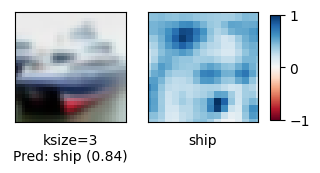

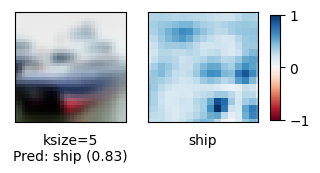

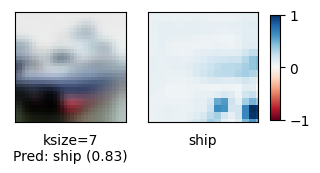

╒════════════════╤════════════════════════╤════════════════════════╤═══════════╤══════════╤══════════╕
│ Perturbation   │   Pos Saliency Entropy │   Neg Saliency Entropy │   Entropy │      SSD │    XCorr │
╞════════════════╪════════════════════════╪════════════════════════╪═══════════╪══════════╪══════════╡
│ Ref Image      │                9.72334 │                5.25907 │   9.85435 │ 0        │ 1        │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=3        │                9.89407 │              nan       │   9.87751 │ 0.354642 │ 0.335319 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=5        │                9.86679 │              nan       │   9.85166 │ 0.322251 │ 0.274195 │
├────────────────┼────────────────────────┼────────────────────────┼───────────┼──────────┼──────────┤
│ ksize=7        │                9.48282 │              nan       │   9.

In [11]:
results = generate_perturbed_sal_maps(
    images=imgs,
    ground_truth=ground_truth,
    image_classifier=classifier,
    saliency_generator=sal_generator,
    ksizes=(3, 5, 7)
)

We can visually see that as the quality of the input image degrades (more perturbation), the quality of the generated saliency maps similarly degrades.

In an attempt to quantify these differences, we've also computed several metrics:

#### Entropy <a name="entropy"></a>

If we compare entropy values using both positive and negative saliency we don't see much of a change across degradations. This is likely due to negative and positive saliency "fighting" each other as degradation increases (as one increases, the other decreases).

If we consider entropy values computed from only positive or only negative saliency values, we see differences in values. Looking at the dominant saliency type (i.e. negative/red for the cat, positive/blue for the ship), we can see that as degradation gets worse, entropy reduces -- to a certain point. The reduction in entropy likely corresponds to the classifier being less able to identify key features that led to the original probability distribution for the reference image due to the degradion. Eventually these features may become so degraded that the classifier begins predicting with very low confidence or nan values if there are no instances of the dominant saliency type. 

If we look at the opposite saliency type for each reference image, we see a very slight increase in entropy as degradation increases. This potentially indicates that the degradation introduces noise that the classifier misidentifies as a contraindicator for the ground truth class, but more likely corresponds to the classifier predicting with less confidence due to the loss in higher quality features.

#### Sum of Squared Differences (SSD) <a name="ssd"></a>

(0 is most similar) The sum of squared differences lets us quantitatively confirm that as degradation gets worse, saliency maps are increasiningly dissimilar to the original reference saliency map. However, the metric doesn't give us much insight into what is actually happening to create these differences.

#### Cross-Correlation (XCorr) <a name="cross-correlation"></a>

(1 is most similar) Cross-correlations tell us similar information as SSD. The introduction of negative correlation values, however, potentially indicates that the saliency maps begin to become the "opposite" of the original reference saliency maps. The aligns with the pattern we saw with positive/negative saliency entropy -- we see an introduction of the opposite saliency as the image becomes more degraded and the classifier becomes more confused. The likely doesn't occur with the ship reference image as it was more strongly salient in one direction compared to the cat reference image was contained a more balanced mix of both positive and negative saliency.